## 01 IMPORTS

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root añadido a sys.path:")
print(PROJECT_ROOT)

Project root añadido a sys.path:
c:\Users\Rodrigo\Desktop\pontia\evaluacion_LLMs\evaluacion_LLMs


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()  # carga .env

# Local modules
from src.rag import build_rag_index, save_rag_index, load_rag_index, retrieve, format_context
from src.llm import chat, extract_text, extract_tool_calls
from src.tools import get_tools_schema, run_tool, weather_result_to_text
from src.memory import ChatMemory


## 02 Config y paths

In [3]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))  # desde notebooks/ a raíz
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

GUIDE_PATH = os.path.join(DATA_DIR, "TENERIFE.pdf")
INDEX_DIR = os.path.join(DATA_DIR, "index_faiss")

print("GUIDE_PATH =", GUIDE_PATH)
print("Existe GUIDE_PATH?:", os.path.exists(GUIDE_PATH))


TOP_K = int(os.getenv("TOP_K", "5"))


GUIDE_PATH = c:\Users\Rodrigo\Desktop\pontia\evaluacion_LLMs\evaluacion_LLMs\data\TENERIFE.pdf
Existe GUIDE_PATH?: True


## 03 Construir/cargar índice RAG

In [4]:
import os

if os.path.exists(os.path.join(INDEX_DIR, "faiss.index")) and os.path.exists(os.path.join(INDEX_DIR, "chunks.json")):
    rag = load_rag_index(INDEX_DIR)
    print("✅ Índice FAISS cargado:", INDEX_DIR)
else:
    rag = build_rag_index(GUIDE_PATH)
    os.makedirs(INDEX_DIR, exist_ok=True)
    save_rag_index(rag, INDEX_DIR)
    print("✅ Índice FAISS creado y guardado en:", INDEX_DIR)

print("Chunks:", len(rag.chunks), "| Dim:", rag.dim, "| Embeddings model:", rag.embed_model)


✅ Índice FAISS cargado: c:\Users\Rodrigo\Desktop\pontia\evaluacion_LLMs\evaluacion_LLMs\data\index_faiss
Chunks: 35 | Dim: 1536 | Embeddings model: text-embedding-3-small


## 04 Memoria de conversación

In [5]:
mem = ChatMemory(
    system_prompt=(
        "Eres un asistente turístico. Responde en español. "
        "Usa el CONTEXTO proporcionado para contestar y cita las fuentes con los ids/páginas "
        "cuando uses información de la guía. "
        "Si necesitas el tiempo para una fecha, llama a la herramienta get_weather."
    ),
    max_turns=8,
    max_chars=12000
)

TOOLS = get_tools_schema()

## 05 Helper para construir prompt con RAG

In [6]:
def build_user_prompt(user_msg: str, rag_context: str) -> str:
    return (
        "CONTEXTO (extractos de la guía; cita usando el id entre corchetes):\n"
        f"{rag_context}\n\n"
        "PREGUNTA DEL USUARIO:\n"
        f"{user_msg}\n\n"
        "INSTRUCCIONES:\n"
        "- Si el contexto contiene la respuesta, úsalo y cita [id | pág. X].\n"
        "- Si el contexto no es suficiente, dilo claramente y sugiere qué faltaría.\n"
        "- Si te preguntan por el tiempo en una fecha concreta, usa get_weather(fecha).\n"
    )

## 06 Orquestador principal answer() (con tool calling)

In [7]:
def answer(user_msg: str, *, top_k: int = TOP_K, verbose: bool = True) -> str:
    # 1) RAG retrieve
    chunks = retrieve(rag, user_msg, top_k=top_k)
    context = format_context(chunks)

    # 2) Añadir el turno del usuario (con contexto “inyectado”)
    mem.add_user(build_user_prompt(user_msg, context))

    # 3) Primera llamada al LLM con tools habilitadas
    resp1 = chat(mem.get_messages(), tools=TOOLS, tool_choice="auto")
    tool_calls = extract_tool_calls(resp1)

    # Si no hay tool calls, devolvemos el texto
    if not tool_calls:
        text = extract_text(resp1)
        mem.add_assistant(text)
        if verbose:
            print(text)
        return text

    # 4) Ejecutar tool calls (pueden ser múltiples)
    tool_summaries = []
    for call in tool_calls:
        name = call.get("name")
        arguments = call.get("arguments")
        out = run_tool(name, arguments)
        summary = weather_result_to_text(out) if name == "get_weather" else str(out)
        tool_summaries.append(f"[Resultado de {name}] {summary}")

    # 5) Meter resultado de tool en memoria
    tool_block = "\n".join(tool_summaries)
    mem.add_tool_result(tool_block)

    # 6) Segunda llamada al LLM para redactar respuesta final (ya con tool result en contexto)
    resp2 = chat(mem.get_messages(), tools=TOOLS, tool_choice="auto")
    final_text = extract_text(resp2)

    mem.add_assistant(final_text)
    if verbose:
        print(final_text)
    return final_text


## 07 Probar conversación multiturno (demo)

In [8]:
print("Quiero un plan de 1 día con cosas típicas para ver. ¿Qué recomiendas?")
answer("Quiero un plan de 1 día con cosas típicas para ver. ¿Qué recomiendas?")

print("Genial. Y para mañana seis de enero del 2026, ¿qué tiempo hará? (usa la fecha en formato YYYY-MM-DD)")
answer("Genial. Y para mañana, ¿qué tiempo hará? (usa la fecha en formato YYYY-MM-DD)")

print("Incluye algún museo mencionado en la guía y dime por qué vale la pena.")
answer("Incluye algún museo mencionado en la guía y dime por qué vale la pena.")


Quiero un plan de 1 día con cosas típicas para ver. ¿Qué recomiendas?
Para un día completo de exploración en Tenerife, te recomiendo el siguiente itinerario:

1. **Mañana en La Laguna**:
   - Comienza el día temprano visitando La Laguna. Puedes callejear hacia la Plaza del Adelantado y disfrutar de un desayuno en la zona. Si hace buen tiempo, considera comer en La Cueva de Casiano y probar la batata con almogrote [p4_c000 | pág. 4].

2. **Parque Rural de Anaga**:
   - Después del desayuno, dirígete al Parque Rural de Anaga, un espacio natural protegido con impresionantes miradores y rutas de senderismo. Es un lugar ideal para disfrutar de la naturaleza y los paisajes. No te pierdas el Mirador de La Jardina y, si el tiempo lo permite, termina en la Playa de Benijo para ver el atardecer [p5_c000 | pág. 5].

3. **Tarde en la Isla Baja**:
   - Por la tarde, puedes explorar la zona de la Isla Baja. Visita Icod de los Vinos para ver el famoso Drago Milenario, luego dirígete a Garachico y, si

'El contexto proporcionado no menciona ningún museo específico. Para incluir un museo en tu itinerario y explicar por qué vale la pena, necesitaría más información sobre los museos disponibles en la zona que estás interesado en visitar. Si tienes alguna otra pregunta o necesitas más detalles, estaré encantado de ayudarte.'

## 08 Pruebas reproducibles (mini evaluación)

In [9]:
test_prompts = [
    "¿Cuáles son los 3 sitios más importantes según la guía? Cita fuentes.",
    "Dame recomendaciones gastronómicas mencionadas en la guía. Cita fuentes.",
    "¿Qué tiempo hará el 2026-01-06?",
    "Hazme un itinerario de 2 días y menciona qué parte viene de la guía."
]

results = []
for p in test_prompts:
    out = answer(p, verbose=False)
    results.append({"prompt": p, "response": out})

results[:4]


[{'prompt': '¿Cuáles son los 3 sitios más importantes según la guía? Cita fuentes.',
  'response': 'El contexto proporcionado no menciona explícitamente los tres sitios más importantes según la guía. Sin embargo, puedo destacar algunos lugares mencionados que parecen ser de interés:\n\n1. **La Laguna**: Recomendada para callejear y disfrutar de lugares como la Plaza del Adelantado y la Plaza de la Iglesia de la Concepción [p4_c000 | pág. 4].\n\n2. **Guachinches en la Zona Norte**: Se destaca la experiencia de comer en un guachinche auténtico, como el Guachinche El Cubano en Santa Úrsula [p24_c001 | pág. 24].\n\n3. **Miradores en Anaga**: Especialmente el Mirador de La Jardina, que es mencionado como un favorito [p5_c001 | pág. 5].\n\nPara una lista más precisa de los sitios más importantes, sería ideal tener más información o un resumen específico de la guía.'},
 {'prompt': 'Dame recomendaciones gastronómicas mencionadas en la guía. Cita fuentes.',
  'response': 'Aquí tienes algunas re

## 09 — Métrica simple + gráfico (para el 15%)

In [10]:
import re
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

def count_citations(text: str) -> int:
    if not isinstance(text, str):
        return 0
    # cuenta patrones tipo [p3_c002 | pág. 3] o [p3_c002]
    return len(re.findall(r"\[p\d+_c\d{3}(\s*\|\s*pág\.\s*\d+)?\]", text))

df["citations"] = df["response"].apply(count_citations)
df


,prompt,response,citations
0,¿Cuáles son los 3 sitios más importantes según...,El contexto proporcionado no menciona explícit...,3
1,Dame recomendaciones gastronómicas mencionadas...,Aquí tienes algunas recomendaciones gastronómi...,6
2,¿Qué tiempo hará el 2026-01-06?,,0
3,Hazme un itinerario de 2 días y menciona qué p...,Aquí tienes un itinerario de 2 días en Tenerif...,6


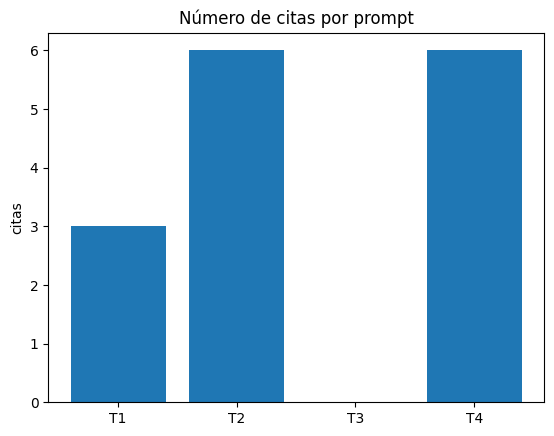

In [11]:
plt.figure()
plt.title("Número de citas por prompt")
plt.bar(range(len(df)), df["citations"])
plt.xticks(range(len(df)), [f"T{i+1}" for i in range(len(df))], rotation=0)
plt.ylabel("citas")
plt.show()


## 10 Chat loop interactivo

In [ ]:
print("💬 Chat interactivo (escribe 'salir' para terminar)\n")

while True:
    try:
        user_msg = input("👤 Tú: ").strip()
        if not user_msg:
            continue
        if user_msg.lower() in {"salir", "exit", "quit"}:
            print("👋 Fin del chat.")
            break

        print("🤖 Asistente:")
        answer(user_msg, verbose=True)
        print("-" * 60)

    except KeyboardInterrupt:
        print("\n👋 Chat interrumpido.")
        break

    except Exception as e:
        print(f"⚠️ Error inesperado: {e}")
        break


💬 Chat interactivo (escribe 'salir' para terminar)

